# Problem 1
We will consider five methods, AdaGrad, RMSProp, RMSProp+Nesterov, AdaDelta, Adam, and study their convergence using CIFAR-10 dataset. We will use multi-layer neural network model with two fully connected hidden layers with 1000 hidden units each and ReLU activation with minibatch size of 128.

## 1
Write the weight update equations for the five adaptive learning rate methods. Explain each term clearly. What are the hyperparameters in each policy? Explain how AdaDelta and Adam are different from RMSProp. (5+1)

We provide the SGD equation first for clearly explaining the following methods.

### SGD
We use $g_{t}$ to denote the gradient at time step $t . g_{t, i}$ is then the partial derivative of the objective function w.r.t. to the parameter $\theta_{i}$ at time step $t$:
\begin{equation}
g_{t, i}=\nabla_{\theta} J\left(\theta_{t, i}\right)
\end{equation}

The SGD update for every parameter $\theta_{i}$ at each time step $t$ then becomes:
\begin{equation}
\theta_{t+1, i}=\theta_{t, i}-\eta \cdot g_{t, i} .
\end{equation}

### AdaGrad
\begin{equation}
\theta_{t+1, i}=\theta_{t, i}-\frac{\eta}{\sqrt{G_{t, i i}+\epsilon}} \cdot g_{t, i}
\end{equation}

$G_{t} \in \mathbb{R}^{d \times d}$ here is a diagonal matrix where each diagonal element $i, i$ is the sum of the squares of the gradients w.r.t. $\theta_{i}$ up to time step $t$, while $\epsilon$ is a smoothing term that avoids division by zero (usually on the order of $1 e-8$ ).

We can also write the vectorized version of the update equation as:

\begin{equation}
\Delta \theta_{t}=-\frac{\eta}{\sqrt{G_{t}+\epsilon}} \odot g_{t}
\end{equation}

\begin{equation}
\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{G_{t}+\epsilon}} \odot g_{t}
\end{equation}

$\eta$ is the learning rate, $\epsilon$ is the smoothing term, and ${G_{t}}$ is the the sum of the squares of the gradients.

Hyperparameters: $\eta$, $\epsilon$


### RMSProp

Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size $w$. The sum of gradients is recursively updated using a decaying average of the past gradients.

\begin{equation}
E\left[g^{2}\right]_{t}=\gamma E\left[g^{2}\right]_{t-1}+(1-\gamma) g_{t}^{2},
\end{equation}


$E\left[g^{2}\right]$ is the decayed average of the past squared gradients, $\epsilon$ is the smoothing term, and $\gamma$ is the decay rate.

\begin{equation}
\Delta \theta_{t}=-\frac{\eta}{\sqrt{E\left[g^{2}\right]_{t}+\epsilon}} g_{t}
\end{equation}

\begin{equation}
\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{E\left[g^{2}\right]_{t}+\epsilon}} g_{t}
\end{equation}

### AdaDelta

\begin{equation}
\Delta \theta_{t}=-\frac{\eta}{R M S[g]_{t}} g_{t}
\end{equation}


\begin{equation}
E\left[\Delta \theta^{2}\right]_{t}=\gamma E\left[\Delta \theta^{2}\right]_{t-1}+(1-\gamma) \Delta \theta_{t}^{2}
\end{equation}

\begin{equation}
R M S[\Delta \theta]_{t}=\sqrt{E\left[\Delta \theta^{2}\right]_{t}+\epsilon}
\end{equation}

\begin{equation}
\begin{aligned}
\Delta \theta_{t} &=-\frac{R M S[\Delta \theta]_{t-1}}{R M S[g]_{t}} g_{t} \\
\theta_{t+1} &=\theta_{t}+\Delta \theta_{t}
\end{aligned}
\end{equation}


**Difference with RMSProp:**
The accumulated gradient $E\left[g^{2}\right]_{t}$ is decayed.

### Adam
We compute the decaying averages of past and past squared gradients $m_{t}$ and $v_{t}$ respectively as follows:

\begin{equation}
\begin{aligned}
m_{t} &=\beta_{1} m_{t-1}+\left(1-\beta_{1}\right) g_{t} \\
v_{t} &=\beta_{2} v_{t-1}+\left(1-\beta_{2}\right) g_{t}^{2}
\end{aligned}
\end{equation}

$m_{t}$ and $v_{t}$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively.

\begin{equation}
\begin{aligned}
\hat{m}_{t} &=\frac{m_{t}}{1-\beta_{1}^{t}} \\
\hat{v}_{t} &=\frac{v_{t}}{1-\beta_{2}^{t}}
\end{aligned}
\end{equation}

\begin{equation}
\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\hat{v}_{t}}+\epsilon} \hat{m}_{t}
\end{equation}


Hyperparameters: $\beta_{1}$, $\beta_{2}$, $\epsilon$

**Difference with RMSProp**:
The gradient is not the decayed sum of squares of the gradients, but the estimated mean of the past gradients.

## 2
Train the neural network using all the five methods with L2-regularization for 200 epochs each and plot the training loss vs number of epochs. Which method performs best (lowest training loss)?

AdaGrad, RMSProp, RMSProp+Nesterov, AdaDelta, Adam

In [4]:
import pytorch_lightning as pl
import torch.nn as nn
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import wandb
from pytorch_lightning.loggers import WandbLogger

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, use_dropout=False):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(hidden_size, output_size)
        self.droup2 = nn.Dropout(0.5)

        self.use_dropout = use_dropout
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.fc1.in_features)
        if self.use_dropout:
            x = self.fc1(x)
            x = self.relu1(x)
            x = self.dropout1(x)
            x = self.fc2(x).squeeze()
            x = self.droup2(x)
        else:
            x = self.fc1(x)
            x = self.relu1(x)
            x = self.fc2(x).squeeze()
        return x

class MLPLightningModule(pl.LightningModule):
    def __init__(self, hidden_size, output_size, optimizer_name='adam', use_dropout=False):
        super(MLPLightningModule, self).__init__()
        self.model = MLP(input_size=3*32*32, hidden_size=hidden_size, output_size=output_size, use_dropout=use_dropout)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer_name = optimizer_name
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        # print(y_hat.shape)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def train_dataloader(self):
        train_dataset = datasets.CIFAR10(root='./cached_datasets/CIFAR10', train=True, download=True, transform=transforms.ToTensor())
        return torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=20)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        return {'val_loss': loss}
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': logs}

    def configure_optimizers(self):
        print(self.optimizer_name, self.optimizer_name == "RMSprop")
        if self.optimizer_name == 'Adagrad':
            optimizer = torch.optim.Adagrad(self.parameters(), lr=0.001, weight_decay=1e-5)
        if self.optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(self.parameters(), lr=0.001, weight_decay=1e-5)
        if self.optimizer_name == 'RMSprop+Nesterov':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
        if self.optimizer_name == 'Adadelta':
            optimizer = torch.optim.Adadelta(self.parameters(), lr=0.001, weight_decay=1e-5)
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        return optimizer

### Adagrad

In [ ]:
run = wandb.init(group='1.2')
run.display(height=720)
optimizer_name = "Adagrad"
wandb.run.name = f"{optimizer_name}_cifar10"
logger = WandbLogger(project='HW3_1', save_dir="./outputs", name=optimizer_name)
trainer = pl.Trainer(gpus=1, max_epochs=200, logger=logger)
model = MLPLightningModule(hidden_size=1000, output_size=10, optimizer_name=optimizer_name)
trainer.fit(model)

### RMSprop

In [10]:
run = wandb.init(group='1.2')
run.display(height=720)
optimizer_name = "RMSprop"
wandb.run.name = f"{optimizer_name}_cifar10"
logger = WandbLogger(project='HW3_1', save_dir="./outputs", name=optimizer_name)
trainer = pl.Trainer(gpus=1, max_epochs=200, logger=logger)
model = MLPLightningModule(hidden_size=1000, output_size=10, optimizer_name=optimizer_name)
trainer.fit(model)

/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:126: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MLP              | 3.1 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.332    Total estimated model params size (MB)


RMSprop True
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


### RMSprop+Nesterov

In [5]:
run = wandb.init(group='1.2')
run.display(height=720)
optimizer_name = "RMSprop+Nesterov"
wandb.run.name = f"{optimizer_name}_cifar10"
logger = WandbLogger(project='HW3_1', save_dir="./outputs", name=optimizer_name)
trainer = pl.Trainer(gpus=1, max_epochs=200, logger=logger)
model = MLPLightningModule(hidden_size=1000, output_size=10, optimizer_name=optimizer_name)
trainer.fit(model)

/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:126: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MLP              | 3.1 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.332    Total estimated model params size (MB)


RMSprop+Nesterov False
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


### Adadelta

In [6]:
run = wandb.init(group='1.2')
run.display(height=720)
optimizer_name = "Adadelta"
wandb.run.name = f"{optimizer_name}_cifar10"
logger = WandbLogger(project='HW3_1', save_dir="./outputs", name=optimizer_name)
trainer = pl.Trainer(gpus=1, max_epochs=200, logger=logger)
model = MLPLightningModule(hidden_size=1000, output_size=10, optimizer_name=optimizer_name)
trainer.fit(model)

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,▁▅▂▂▁▂▄▂▁▂▂▂▃▃▂▅▂▃▂▁▂▂▂▃▂▂▃▂▃▂▂▂▃█▂▃▂▂▂▄
train_loss_step,▁▂█▁▂▁▁▁▆▂▁▁▁▁▂▂▃▂▃▁▁▂▂▁▁▃▁▂▁▄▂▁▁█▁▂▁▅▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,200
train_loss_epoch,4.10967
train_loss_step,2.14456
trainer/global_step,78199


/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:126: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MLP              | 3.1 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.332    Total estimated model params size (MB)


Adadelta False
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

/home/xiangpan/.conda/envs/39/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


### Adam

In [ ]:
run = wandb.init(group='1.2')
run.display(height=720)
optimizer_name = "Adam"
wandb.run.name = f"{optimizer_name}_cifar10"
logger = WandbLogger(project='HW3_1', save_dir="./outputs", name=optimizer_name)
trainer = pl.Trainer(gpus=1, max_epochs=200, logger=logger)
model = MLPLightningModule(hidden_size=1000, output_size=10, optimizer_name=optimizer_name)
trainer.fit(model)

### Plot

In [13]:
import pandas as pd
df = pd.read_csv("./problem1/1_2.csv")
df

,epoch,RMSprop_cifar10 - _step,RMSprop_cifar10 - _step__MIN,RMSprop_cifar10 - _step__MAX,RMSprop_cifar10 - train_loss_epoch,RMSprop_cifar10 - train_loss_epoch__MIN,RMSprop_cifar10 - train_loss_epoch__MAX,RMSprop+Nesterov_cifar10 - _step,RMSprop+Nesterov_cifar10 - _step__MIN,RMSprop+Nesterov_cifar10 - _step__MAX,...,Adagrad_cifar10 - _step__MAX,Adagrad_cifar10 - train_loss_epoch,Adagrad_cifar10 - train_loss_epoch__MIN,Adagrad_cifar10 - train_loss_epoch__MAX,Adadelta_cifar10 - _step,Adadelta_cifar10 - _step__MIN,Adadelta_cifar10 - _step__MAX,Adadelta_cifar10 - train_loss_epoch,Adadelta_cifar10 - train_loss_epoch__MIN,Adadelta_cifar10 - train_loss_epoch__MAX
0,1,7,7,7,2.663809,2.663809,2.663809,7,7,7,...,7,1.961369,1.961369,1.961369,7,7,7,2.268250,2.268250,2.268250
1,2,16,16,16,1.774574,1.774574,1.774574,16,16,16,...,16,1.823225,1.823225,1.823225,16,16,16,2.214725,2.214725,2.214725
2,3,25,25,25,1.688607,1.688607,1.688607,25,25,25,...,25,1.772303,1.772303,1.772303,25,25,25,2.173219,2.173219,2.173219
3,4,34,34,34,1.636065,1.636065,1.636065,34,34,34,...,34,1.737732,1.737732,1.737732,34,34,34,2.138775,2.138775,2.138775
4,5,43,43,43,1.593487,1.593487,1.593487,43,43,43,...,43,1.710066,1.710066,1.710066,43,43,43,2.109075,2.109075,2.109075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,1727,1727,1727,0.792143,0.792143,0.792143,1727,1727,1727,...,1727,1.220296,1.220296,1.220296,1727,1727,1727,1.572403,1.572403,1.572403
196,197,1736,1736,1736,0.797538,0.797538,0.797538,1736,1736,1736,...,1736,1.219495,1.219495,1.219495,1736,1736,1736,1.571365,1.571365,1.571365
197,198,1745,1745,1745,0.793693,0.793693,0.793693,1745,1745,1745,...,1745,1.218581,1.218581,1.218581,1745,1745,1745,1.570372,1.570372,1.570372
198,199,1754,1754,1754,0.793397,0.793397,0.793397,1754,1754,1754,...,1754,1.217557,1.217557,1.217557,1754,1754,1754,1.569414,1.569414,1.569414


In [23]:
ori_optimize_name_list = ["Adagrad", "RMSprop", "RMSprop+Nesterov", "Adadelta", "Adam"]
post_fix = "_cifar10 - train_loss_epoch"
optimize_name_list = [x + post_fix for x in ori_optimize_name_list]
data = df[optimize_name_list]

Text(0, 0.5, 'train_loss')

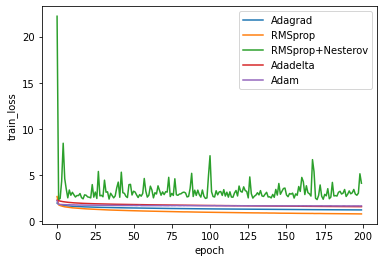

In [30]:
# plot data
import matplotlib.pyplot as plt
data = df[optimize_name_list]
plt.plot(data)
plt.legend(ori_optimize_name_list)
plt.xlabel("epoch")
plt.ylabel("train_loss")

Text(0, 0.5, 'train_loss')

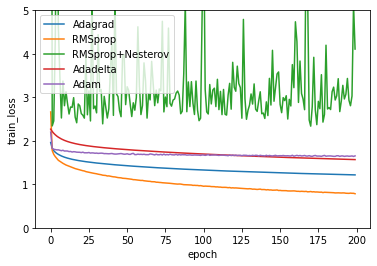

In [31]:
# plot data
import matplotlib.pyplot as plt
data = df[optimize_name_list]
plt.plot(data)
plt.legend(ori_optimize_name_list)
plt.ylim(0, 5)
plt.xlabel("epoch")
plt.ylabel("train_loss")

RMSprop+Nesterov performs best.

## 3
Add dropout (probability 0.2 for input layer and 0.5 for hidden layers) and train the neural network again using all the five methods for 200 epochs. Compare the training loss with that in part 2. Which method performs the best? For the five methods, compare their training time (to finish 200 epochs with dropout) to the training time in part 2 (to finish 200 epochs without dropout). (5)